**Grupo 1**


1. Clausio Barbosa - cttb@cesar.school
2. Enio Kilder - ekos@cesar.school
3. Filipe Amado - fav@cesar.school
4. Thiago Tenório - tbat@cesar.school

In [ ]:
pip install yfinance pydataset pmdarima tqdm

In [ ]:
import yfinance as yf
from pydataset import data
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [ ]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}

In [ ]:
def arima_fit_predict(ts, m, horizon, test_size):
  ts_train = ts[0:-(test_size+(horizon-1))].values
  ts_test = ts[-(test_size+(horizon-1)):].values

  model = auto_arima(ts_train, #X=None,
            start_p=2, start_q=2, max_p=5, max_d=2,
            max_q=5, start_P=1, start_Q=1, max_P=2,
            max_D=1, max_Q=2, max_order=10, m=m,
            stepwise=True, trace=True)

  direct_predict = model.predict(ts_test.shape[0])

  prevs_h_steps = []

  for t in tqdm(ts_test):
    prevs_h_steps.append(model.predict(horizon)[horizon-1])
    model.update(t)

  return prevs_h_steps[0:test_size], direct_predict[-test_size:]


def show_tendencia(ts, rm_size):
  df_show = pd.DataFrame()

  df_show['serie'] = ts.values[rm_size:]
  df_show['rm'] = ts.rolling(rm_size).mean().values[rm_size:]

  df_show['date'] = ts.index.to_list()[rm_size:]
  df_show.set_index('date', inplace=True)
  df_show.plot()
  plt.show()

**Análise - Monthly milk production: pounds per cow. Adjusted for length of month (1962–1975)**

In [ ]:
db_milk_link = 'https://raw.githubusercontent.com/tbatenorio/Time_Series_Analysis/main/milk.txt'

db_milk = pd.read_csv(db_milk_link)
db_milk.head(10)

,578.3
0,609.8
1,628.4
2,665.6
3,713.8
4,707.2
5,628.4
6,588.1
7,576.3
8,566.5
9,561.1


<Axes: xlabel='date'>

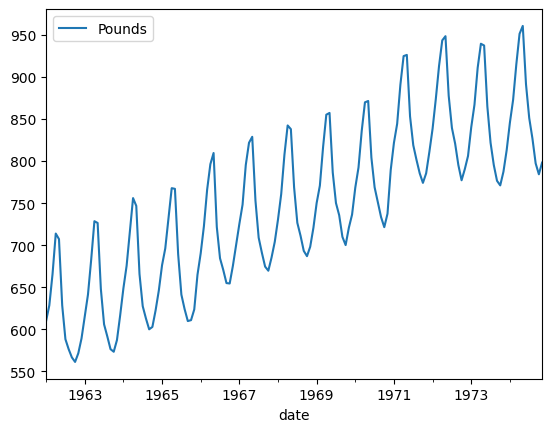

In [ ]:
db_milk.rename(columns={db_milk.columns[0]: 'Pounds'}, inplace=True)

db_milk['date'] = pd.date_range(
    start='1962-01-01', end= '1974-12-30', freq='M'
  )
db_milk.set_index('date', inplace=True)

db_milk.plot()

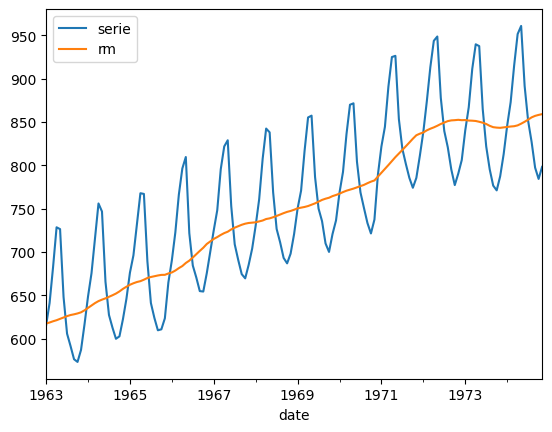

In [ ]:
ts = db_milk['Pounds']
rm_size = 12
show_tendencia(ts, rm_size)

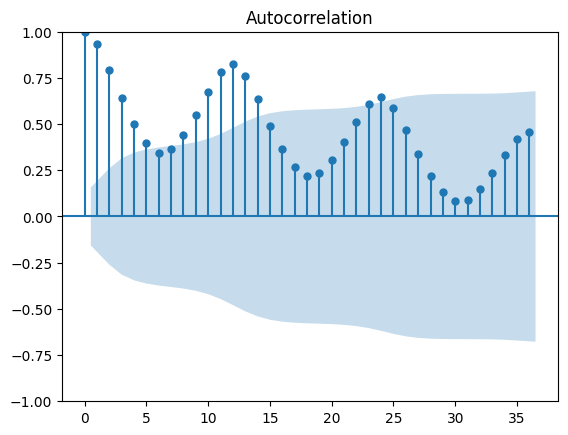

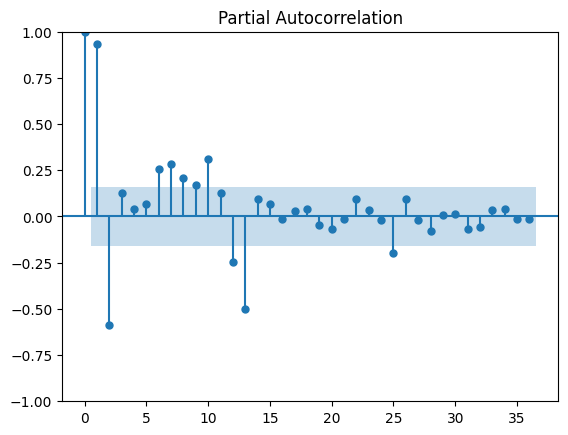

In [ ]:
plot_acf(ts, lags=36)
plt.show()
plot_pacf(ts, lags=36)
plt.show()

In [ ]:
kpss = KPSSTest()
kpss.should_diff(ts)

(0.01, True)

<Axes: xlabel='date'>

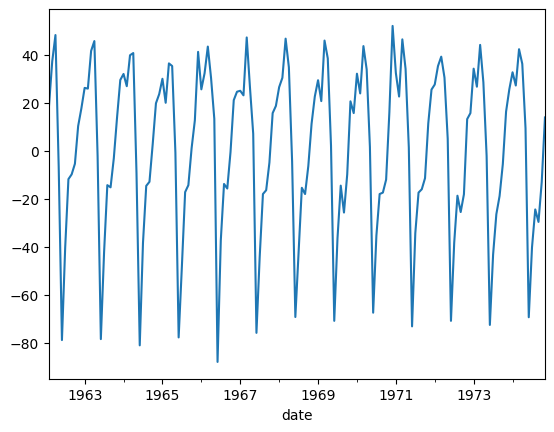

In [ ]:
#Aplicando a Diferenciação
db_milk_diff = ts.diff().iloc[1:]
db_milk_diff.plot()

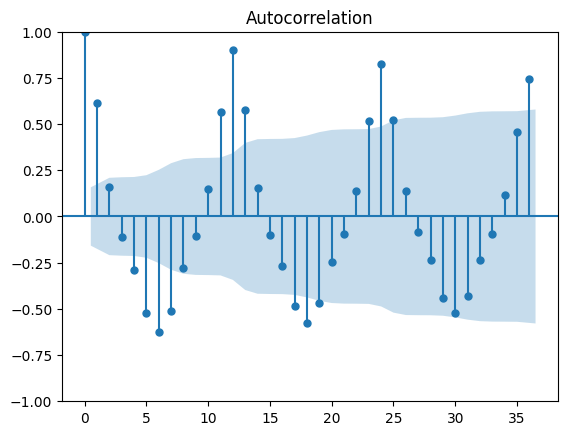

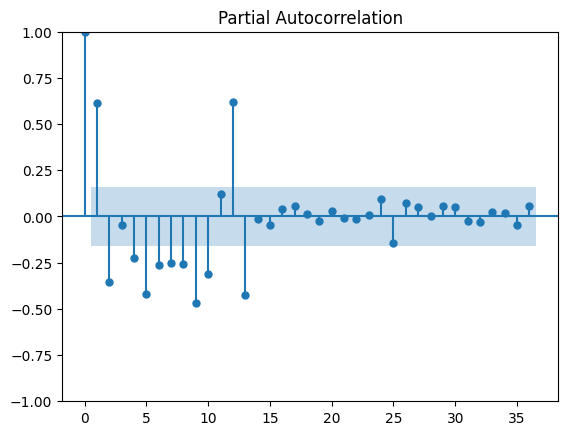

In [ ]:
plot_acf(db_milk_diff, lags=36)
plt.show()
plot_pacf(db_milk_diff, lags=36)
plt.show()

In [ ]:
test_size = 46 #Em torno de 30% da base
m = 12
horizon = 1
ts = db_milk
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=645.337, Time=3.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=738.977, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=643.114, Time=0.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=668.423, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=894.341, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=655.931, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=644.177, Time=2.02 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=639.975, Time=1.50 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=638.744, Time=0.61 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=640.255, Time=1.75 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=7.37 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=640.725, Time=0.85 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=640.727, Time=0.96 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AI

100%|██████████| 46/46 [00:16<00:00,  2.74it/s]


<Axes: xlabel='date'>

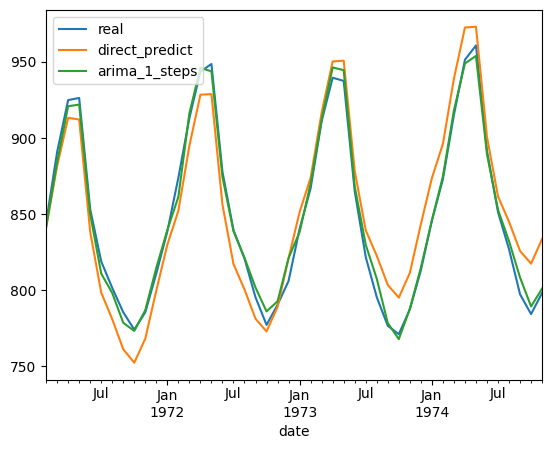

In [ ]:
df_result = pd.DataFrame(
    {
        'real': ts['Pounds'].iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result.plot()

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['direct_predict','arima_1_steps']:

  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,368.674346,19.200894,2.087621,17.486057,0.338171,0.108763,93.478261,direct_predict
1,30.543626,5.526629,0.514421,4.336033,0.028047,0.009732,95.652174,arima_1_steps


In [ ]:
def diferenciar(dt: pd.DataFrame, horizonte=1) -> pd.DataFrame:
    dt_diferenciado = dt.copy()

    dt_diferenciado = dt_diferenciado - dt_diferenciado.shift(horizonte)

    dt_diferenciado = dt_diferenciado.dropna()

    return dt_diferenciado

def reverter_diferenciacao(dt_original: pd.DataFrame, dt_diferenciado: pd.DataFrame, horizonte=1) -> pd.DataFrame:

    dt_revertido = dt_original.shift(horizonte) + dt_diferenciado

    dt_revertido = dt_revertido.dropna()

    return dt_revertido

def criar_janela(dt: pd.DataFrame, lag=0, horizonte=1, sazonalidade=0, deve_diferenciar=False) -> pd.DataFrame:
    dt_janela = dt.copy()

    if deve_diferenciar:
        dt_janela = diferenciar(dt_janela, horizonte)

    for i in np.arange(horizonte, horizonte + lag):
        dt_janela = dt_janela.merge(dt_janela[dt.columns].shift(i), left_index=True, right_index=True, suffixes=['',f'_lag_{i}'])

    if sazonalidade >= lag + horizonte:
        dt_janela = dt_janela.merge(dt_janela[dt.columns].shift(sazonalidade), left_index=True, right_index=True, suffixes=['',f'_lag_{sazonalidade}'])

    dt_janela = dt_janela.dropna()

    return dt_janela

def predicao_sklearn(dt: pd.DataFrame, lag=0, horizonte=1, sazonalidade=0, deve_diferenciar=False, test_size=1, model=SVR(C=100)):

  ts_lagged = criar_janela(dt,lag=lag,horizonte=horizonte,sazonalidade=sazonalidade,deve_diferenciar=deve_diferenciar)

  x_train = ts_lagged.iloc[0:-test_size][ts_lagged.columns[1:]].values
  y_train = ts_lagged.iloc[0:-test_size][ts_lagged.columns[0]].values.reshape(-1,1)

  x_test = ts_lagged.iloc[-test_size:][ts_lagged.columns[1:]].values

  x_scale = MinMaxScaler()
  x_train_norm = x_scale.fit_transform(x_train)
  x_test_norm = x_scale.transform(x_test)

  y_scale = MinMaxScaler()
  y_train_norm = y_scale.fit_transform(y_train)

  model.fit(x_train_norm, y_train_norm)
  y_pred = model.predict(x_test_norm)

  y_pred = y_scale.inverse_transform(y_pred.reshape(-1,1)).flatten()

  y_pred = pd.DataFrame(y_pred, index=ts_lagged.iloc[-test_size:].index, columns=dt.columns)

  if deve_diferenciar:
      y_pred = reverter_diferenciacao(dt, y_pred)

  return y_pred


In [ ]:
df_MLP = predicao_sklearn(dt=ts,lag=3,horizonte=1,sazonalidade=12, test_size=46, deve_diferenciar=True, model=MLPRegressor(solver = 'lbfgs'))
df_SVR = predicao_sklearn(dt=ts,lag=3,horizonte=1,sazonalidade=12, test_size=46, deve_diferenciar=True, model=SVR(C=100))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: xlabel='date'>

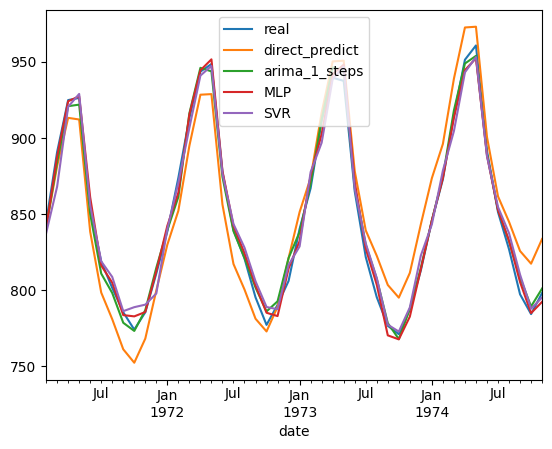

In [ ]:
df_result = pd.DataFrame(
    {
        'real': ts['Pounds'].iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
        'MLP': df_MLP['Pounds'],
        'SVR': df_SVR['Pounds'],
    }
)
df_result.plot()

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in df_result.columns.drop('real'):

  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,368.674346,19.200894,2.087621,17.486057,0.338171,0.108763,93.478261,direct_predict
1,30.543626,5.526629,0.514421,4.336033,0.028047,0.009732,95.652174,arima_1_steps
2,29.956234,5.473229,0.538200,4.530820,0.026722,0.009341,93.478261,MLP
3,66.189433,8.135689,0.768076,6.481767,0.060223,0.022723,91.304348,SVR


**Comparando os 3 modelos de aprendizagem de máquina (ARIMA, MLP, SVR), obtivemos as seguintes conclusões:**

1) Os modelo ARIMA e MLP apresentaram resultados semelhantes e tiveram o melhor desempenho.

2) O SVR também apresentou bom resultado, porém com as métricas um pouco piores dos anteriores.

3) O ARIMA com predição direta obeteve opior resultado dentros os modelos apresentados.